<a href="https://colab.research.google.com/github/StanleyLiangYork/Advance_NN_techniques/blob/main/customized_traning_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import shutil
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

Get the flower dataset <p>
flower_photo/ <p>
  daisy/ <p>
  dandelion/ <p>
  roses/ <p>
  sunflowers/ <p>
  tulips/ <p>

In [ ]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 6s 0us/step


In [ ]:
if not os.path.exists('flower_photos'):
  folder = os.mkdir('flower_photos')

source_dir = data_dir
target_dir = './flower_photos'
file_names = os.listdir(source_dir)
    
for file_name in file_names:
  shutil.move(os.path.join(source_dir, file_name), target_dir)

In [ ]:
data_dir = pathlib.Path(target_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(f'There are {image_count} flower images in total')

There are 3670 flower images in total


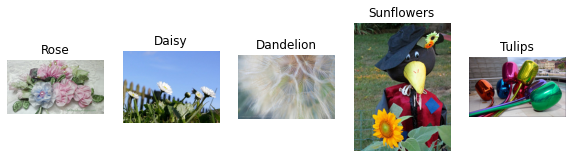

In [ ]:
import random

show_img = []
show_img.append(list(data_dir.glob('roses/*')))
show_img.append(list(data_dir.glob('daisy/*')))
show_img.append(list(data_dir.glob('dandelion/*')))
show_img.append(list(data_dir.glob('sunflowers/*')))
show_img.append(list(data_dir.glob('tulips/*')))

imgs = []
for img in show_img:
  pic = (random.choice(img))
  imgs.append(PIL.Image.open(str(pic)))

labels = ['Rose', 'Daisy', 'Dandelion', 'Sunflowers', 'Tulips']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 8))

for i in range(5):
  plt.subplot(1,5,i+1)
  plt.imshow(imgs[i])
  plt.title(labels[i])
  plt.axis('off')

Data Preprocessing

In [ ]:
def process_img(file_path):
  # load the raw data from the file name list as a string
  img = tf.io.read_file(file_path) # read as binary
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.cast(img, tf.float32)
  # img = (img / 127.5) - 1
  img = img / 255.0
  img = tf.image.resize(img, (128, 128))
  return img

In [ ]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [ ]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [ ]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [ ]:
print(f'the training set has {tf.data.experimental.cardinality(train_ds).numpy()} images')
print(f'the validation set has {tf.data.experimental.cardinality(val_ds).numpy()} images')

the training set has 2936 images
the validation set has 734 images


In [ ]:
def get_label(file_path):
  # split the file part
  parts = tf.strings.split(file_path, os.path.sep)
  # use the sub-folder as label
  # return a tensor of logic values
  one_hot = parts[-2] == class_names
  # get the max (True) index and encode as Integer
  # index start from zero
  return tf.argmax(one_hot)

In [ ]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # cast the pixel from int to float32
  img = tf.cast(img, tf.float32)
  # rescale the pixels to [-1,1]
  img = (img / 127.5) - 1
  # resize the image to the desired size
  return tf.image.resize(img, [128, 128])

In [ ]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

Map the process_path function to the dataset object to get the image numpy matrices

In [ ]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

.cache() keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache. <p>
.prefetch() overlaps data preprocessing and model execution while training.

In [ ]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE).batch(128)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE).batch(128)

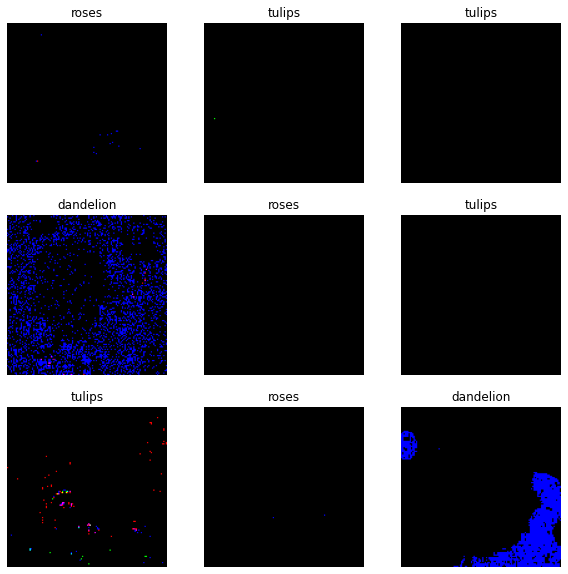

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Train a regular CNN

In [ ]:
num_classes = 5

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(128, 128,3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

model = tf.keras.Sequential([
  tf.keras.Input(shape=(128,128,3)),
  data_augmentation,
  layers.ZeroPadding2D(padding=(1,1)),
  layers.Conv2D(32, 3, activation='relu', padding='same'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu', padding='same'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu', padding='same'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 128, 128, 3)       0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 130, 130, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 130, 130, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 65, 65, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 65, 65, 32)        9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 32)       

In [ ]:
# since we use an integer, NOT one-hot encode, the loss should be sparse categorical crossentropy
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs=50
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/50
23/23 [==============================] - 2s 48ms/step - loss: 1.4810 - accuracy: 0.3377 - val_loss: 1.2197 - val_accuracy: 0.5041
Epoch 2/50
23/23 [==============================] - 1s 44ms/step - loss: 1.1561 - accuracy: 0.5095 - val_loss: 1.1961 - val_accuracy: 0.5531
Epoch 3/50
23/23 [==============================] - 1s 43ms/step - loss: 1.0888 - accuracy: 0.5312 - val_loss: 1.1441 - val_accuracy: 0.5695
Epoch 4/50
23/23 [==============================] - 1s 43ms/step - loss: 1.0403 - accuracy: 0.5692 - val_loss: 1.1642 - val_accuracy: 0.5722
Epoch 5/50
23/23 [==============================] - 1s 43ms/step - loss: 0.9904 - accuracy: 0.5970 - val_loss: 1.0504 - val_accuracy: 0.6117
Epoch 6/50
23/23 [==============================] - 1s 43ms/step - loss: 0.9453 - accuracy: 0.6326 - val_loss: 1.0262 - val_accuracy: 0.6335
Epoch 7/50
23/23 [==============================] - 1s 43ms/step - loss: 0.8960 - accuracy: 0.6499 - val_loss: 1.0343 - val_accuracy: 0.6349
Epoch 8/50
23

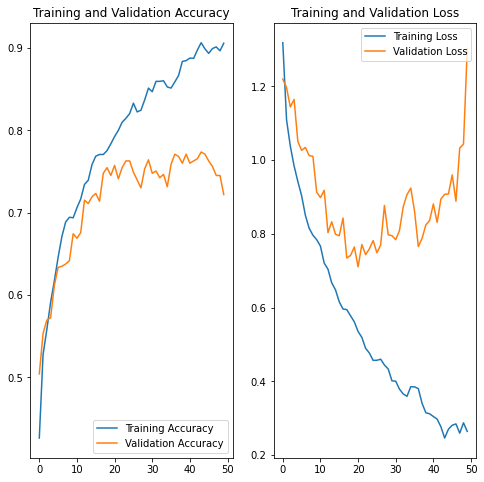

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Customized the training**

In [ ]:
# define a loss objective

def loss(model, x, y, training):
  # training=training is needed only if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  y_hat = model(x, training=training)

  return loss_object(y_true=y, y_pred=y_hat)

In [ ]:
feats, labels = next(iter(train_ds))
l = loss(model, feats, labels, training=False)
print("Loss test: {}".format(l))

NameError: ignored

In [ ]:
# define the gradient for back prop

def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets, training=True)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [ ]:
for i in range(5):
  loss_value, grads = grad(model, feats, labels)
  print('some gradient descent walk without an optimizer...')
  print("Step: {}, Initial Loss: {}".format(i+1, loss_value.numpy()))

some gradient descent walk without an optimizer...
Step: 1, Initial Loss: 0.33181920647621155
some gradient descent walk without an optimizer...
Step: 2, Initial Loss: 0.3982234299182892
some gradient descent walk without an optimizer...
Step: 3, Initial Loss: 0.4253356456756592
some gradient descent walk without an optimizer...
Step: 4, Initial Loss: 0.34417933225631714
some gradient descent walk without an optimizer...
Step: 5, Initial Loss: 0.4224693179130554


Some gradient descent walk

In [ ]:
# define the optimizer
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.002)

In [ ]:
for i in range(10):
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  print("Step: {}, Loss: {}".format(optimizer.iterations.numpy(), loss(model, feats, labels, training=True).numpy()))

Step: 32, Loss: 21122.44140625
Step: 33, Loss: 23642.060546875
Step: 34, Loss: 26047.89453125
Step: 35, Loss: 28935.17578125
Step: 36, Loss: 32364.208984375
Step: 37, Loss: 35765.5703125
Step: 38, Loss: 39265.234375
Step: 39, Loss: 42929.03515625
Step: 40, Loss: 47172.68359375
Step: 41, Loss: 52144.00390625


A customized training loop

In [ ]:
# define the model
model_2 = tf.keras.Sequential([
  tf.keras.Input(shape=(128,128,3)),
  data_augmentation,                   
  layers.Conv2D(32, 3, activation='relu', padding='same'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu', padding='same'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu', padding='same'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model_2.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 16, 16, 32)       

In [ ]:
train_loss_results = []
train_accuracy_results = []
val_loss_results = []
val_accuracy_results = []

train_loss_avg = tf.keras.metrics.Mean()
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
val_loss_avg = tf.keras.metrics.Mean()
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

num_epochs = 100

for epoch in range(num_epochs):
  # update by training set
  for x, y in train_ds:
    # get the gradients and the loss value
    loss_value, grads = grad(model_2, x, y)
    # optimize the model
    optimizer.apply_gradients(zip(grads, model_2.trainable_variables))

    # record the training progress
    train_loss_avg.update_state(loss_value) 
    # training must be True, we have a dropout layer
    train_accuracy.update_state(y, model_2(x, training=True))

    # End epoch - all data pass the model for one time
  train_loss_results.append(train_loss_avg.result())
  train_accuracy_results.append(train_accuracy.result())
  
  # run validation
  for x_val, y_val in val_ds:
    val_logits = model_2(x_val, training=False)
    val_loss_avg.update_state(loss(model_2, x_val, y_val, training=False))
    val_accuracy.update_state(y_val, val_logits)

  val_loss_results.append(val_loss_avg.result())
  val_accuracy_results.append(val_accuracy.result())

  # every 5 epoch display the progress
  if epoch % 5 == 0:
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}; val_loss: {:.3f}, val_acc: {:.3%}.".format(epoch,train_loss_avg.result(),train_accuracy.result(), 
                                                                                                    val_loss_avg.result(), val_accuracy.result()))

  # result the loss and accuracy metrics
  train_loss_avg.reset_states()
  train_accuracy.reset_states()
  val_loss_avg.reset_states()
  val_accuracy.reset_states()


  

Epoch 000: Loss: 1.729, Accuracy: 36.819%; val_loss: 1.372, val_acc: 39.782%.
Epoch 005: Loss: 0.953, Accuracy: 66.144%; val_loss: 1.219, val_acc: 56.131%.
Epoch 010: Loss: 0.730, Accuracy: 75.988%; val_loss: 1.157, val_acc: 63.079%.
Epoch 015: Loss: 0.605, Accuracy: 80.790%; val_loss: 0.922, val_acc: 70.845%.
Epoch 020: Loss: 0.521, Accuracy: 82.732%; val_loss: 1.177, val_acc: 66.213%.
Epoch 025: Loss: 0.438, Accuracy: 86.410%; val_loss: 0.868, val_acc: 73.161%.
Epoch 030: Loss: 0.344, Accuracy: 89.680%; val_loss: 1.023, val_acc: 71.390%.
Epoch 035: Loss: 0.303, Accuracy: 91.451%; val_loss: 1.057, val_acc: 72.752%.
Epoch 040: Loss: 0.273, Accuracy: 92.405%; val_loss: 1.120, val_acc: 72.071%.
Epoch 045: Loss: 0.234, Accuracy: 93.699%; val_loss: 1.268, val_acc: 73.706%.
Epoch 050: Loss: 0.214, Accuracy: 94.380%; val_loss: 1.396, val_acc: 73.297%.
Epoch 055: Loss: 0.182, Accuracy: 95.334%; val_loss: 1.484, val_acc: 73.706%.
Epoch 060: Loss: 0.156, Accuracy: 96.526%; val_loss: 1.764, val_

Improve training runtime by Tensorflow graph functions



In [ ]:
train_loss_records = []
train_acc_records = []
val_loss_records = []
val_acc_records = []

train_loss_avg = tf.keras.metrics.Mean()
train_acc = tf.keras.metrics.SparseCategoricalAccuracy()
val_loss_avg = tf.keras.metrics.Mean()
val_acc = tf.keras.metrics.SparseCategoricalAccuracy()

# define the optimizer
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.002)

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(128, 128,3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)


@tf.function
def loss_fn(model, x, y, training):
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  logits = model(x, training=training)
  return loss_object(y_true=y, y_pred=logits)


@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        loss_value = loss_fn(model, x, y, training=True)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_acc.update_state(y, model(x, training=True))
    train_loss_avg.update_state(loss_value)
    return loss_value


@tf.function
def test_step(x, y):
    val_acc.update_state(y, model(x, training=False))
    val_loss = loss_fn(model, x, y, training=False)
    val_loss_avg.update_state(val_loss)

In [ ]:
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.Input(shape=(128,128,3)),
  data_augmentation,                   
  layers.Conv2D(32, 3, activation='relu', padding='same'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu', padding='same'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu', padding='same'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


import time

epochs = 10
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    start_time = time.time()

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_ds):
        loss_value = train_step(x=x_batch_train, y=y_batch_train)

    train_loss_records.append(train_loss_avg.result())
    train_acc_records.append(train_acc.result())
    # Run a validation loop at the end of each epoch.
    for x_batch_val, y_batch_val in val_ds:
        test_step(x=x_batch_val, y=y_batch_val)
    
    val_loss_records.append(val_loss_avg.result())
    val_acc_records.append(val_acc.result())
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}; Val_loss: {:.3f}, Val_acc: {:.3%}".format(epoch, train_loss_avg.result(), train_acc.result(), val_loss_avg.result(), val_acc.result()))

    # Reset the metrics at the end of each epoch
    train_loss_avg.reset_states()
    train_acc.reset_states()
    val_loss_avg.reset_states()
    val_acc.reset_states()
    print("Time taken: %.2fs" % (time.time() - start_time))


Start of epoch 0
Epoch 000: Loss: 1.865, Accuracy: 36.376%; Val_loss: 1.218, Val_acc: 47.956%
Time taken: 2.82s

Start of epoch 1
Epoch 001: Loss: 1.211, Accuracy: 52.214%; Val_loss: 1.116, Val_acc: 52.861%
Time taken: 0.81s

Start of epoch 2
Epoch 002: Loss: 1.122, Accuracy: 59.094%; Val_loss: 1.056, Val_acc: 57.629%
Time taken: 0.81s

Start of epoch 3
Epoch 003: Loss: 1.066, Accuracy: 62.091%; Val_loss: 0.976, Val_acc: 61.853%
Time taken: 0.82s

Start of epoch 4
Epoch 004: Loss: 0.987, Accuracy: 65.191%; Val_loss: 0.921, Val_acc: 63.215%
Time taken: 0.82s

Start of epoch 5
Epoch 005: Loss: 0.939, Accuracy: 66.962%; Val_loss: 0.946, Val_acc: 61.580%
Time taken: 0.82s

Start of epoch 6
Epoch 006: Loss: 0.916, Accuracy: 68.154%; Val_loss: 0.936, Val_acc: 61.853%
Time taken: 0.82s

Start of epoch 7
Epoch 007: Loss: 0.847, Accuracy: 71.219%; Val_loss: 0.878, Val_acc: 64.305%
Time taken: 0.82s

Start of epoch 8
Epoch 008: Loss: 0.786, Accuracy: 73.433%; Val_loss: 1.146, Val_acc: 57.766%
T

Use the train model for prediction

In [ ]:
features, labels = next(iter(val_ds))

In [ ]:
predictions = model(features, training=False)

In [ ]:
labels.shape

TensorShape([128])

In [ ]:
acc = np.zeros(labels.shape)
print(acc)
for i, logits in enumerate(predictions):
  class_idx = tf.argmax(logits).numpy()
  p = tf.nn.softmax(logits)[class_idx]
  name = class_names[class_idx]
  # print("Example {} prediction: {} ({:4.1f}%)".format(i, name, 100*p))
  if class_idx == labels[i]:
    acc[i] = 1

print(f'The accuracy is {acc.sum() / acc.shape[0] * 100}%')

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
The accuracy is 57.03125%


Define and Train a GAN model

In [ ]:
discriminator = keras.Sequential(
    [
        tf.keras.Input(shape=(128, 128, 3)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        1792      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
global_max_pooling2d (Global (None, 128)             

 create a generator network, that turns latent vectors into outputs of shap (28, 28, 1)

In [ ]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        # We want to generate 128 coefficients to reshape into a 7x7x128 map
        layers.Dense(16 * 16 * 128),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((16, 16, 128)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"), # 16*16 -- 32*32
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"), # 32*32 -- 64*64
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding="same"), # 32*32 -- 64*64
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, (128, 128), padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32768)             4227072   
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 32768)             0         
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 128)       262272    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 64, 64, 128)       262272    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 64, 64, 128)       0 

In [ ]:
# Instantiate one optimizer for the discriminator and another for the generator.
d_optimizer = keras.optimizers.Adam(learning_rate=0.0003)
g_optimizer = keras.optimizers.Adam(learning_rate=0.0004)

# Instantiate a loss function.
loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)


@tf.function
def train_step(real_images):
    # Sample random points in the latent space
    random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))
    # Decode them to fake images
    generated_images = generator(random_latent_vectors)
    # Combine them with real images
    combined_images = tf.concat([generated_images, real_images], axis=0)

    # Assemble labels discriminating real from fake images
    labels = tf.concat(
        [tf.ones((batch_size, 1)), tf.zeros((real_images.shape[0], 1))], axis=0
    )
    # Add random noise to the labels - important trick!
    labels += 0.05 * tf.random.uniform(labels.shape)

    # Train the discriminator
    with tf.GradientTape() as tape:
        predictions = discriminator(combined_images)
        d_loss = loss_fn(labels, predictions)
    grads = tape.gradient(d_loss, discriminator.trainable_weights)
    d_optimizer.apply_gradients(zip(grads, discriminator.trainable_weights))

    # Sample random points in the latent space
    random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))
    # Assemble labels that say "all real images"
    misleading_labels = tf.zeros((batch_size, 1))

    # Train the generator (note that we should *not* update the weights
    # of the discriminator)!
    with tf.GradientTape() as tape:
        predictions = discriminator(generator(random_latent_vectors), training=False)
        g_loss = loss_fn(misleading_labels, predictions)
    grads = tape.gradient(g_loss, generator.trainable_weights)
    g_optimizer.apply_gradients(zip(grads, generator.trainable_weights))
    return d_loss, g_loss, generated_images

In [ ]:
if not os.path.exists('syn_images'):
  folder = os.mkdir('syn_images')

In [ ]:
def process_path(file_path):
  img = process_img(file_path)
  return img


AUTOTUNE = tf.data.AUTOTUNE
dataset = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE).batch(128)


Start epoch 0
discriminator loss at step 0: 0.67
adversarial loss at step 0: 0.68
discriminator loss at step 10: 0.66
adversarial loss at step 10: 0.67
discriminator loss at step 20: 0.50
adversarial loss at step 20: 0.89

Start epoch 1
discriminator loss at step 0: 0.28
adversarial loss at step 0: 1.22
discriminator loss at step 10: 0.10
adversarial loss at step 10: 2.35
discriminator loss at step 20: 0.01
adversarial loss at step 20: 4.78

Start epoch 2
discriminator loss at step 0: -0.02
adversarial loss at step 0: 7.49
discriminator loss at step 10: -0.07
adversarial loss at step 10: 11.31
discriminator loss at step 20: -0.11
adversarial loss at step 20: 17.59

Start epoch 3
discriminator loss at step 0: 0.12
adversarial loss at step 0: 2.24
discriminator loss at step 10: 0.06
adversarial loss at step 10: 3.48
discriminator loss at step 20: 0.06
adversarial loss at step 20: 4.62

Start epoch 4
discriminator loss at step 0: 0.01
adversarial loss at step 0: 5.62
discriminator loss a

KeyboardInterrupt: ignored

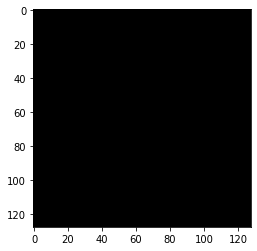

In [18]:
save_dir = "./syn_images"
batch_size = 128
epochs = 30

for epoch in range(epochs):
  print("\nStart epoch", epoch)

  for step, real_images in enumerate(dataset):
    d_loss, g_loss, generated_images = train_step(real_images)

    if step % 10 == 0:
      print("discriminator loss at step {:d}: {:.2f}".format(step, d_loss))
      print("adversarial loss at step {:d}: {:.2f}".format(step, g_loss))

      img = tf.keras.preprocessing.image.array_to_img(
                generated_images[0] * 255.0, scale=False
            )
      plt.imshow(img)
      img.save(os.path.join(save_dir, "generated_img" + str(step) + ".png"))
